In [1]:
import autograd.numpy as np
from autograd import grad
from scipy import optimize
import matplotlib.pyplot as plt


### Import Data

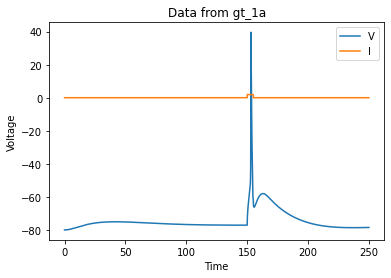

In [2]:
import zipfile
import csv

fname = 'gt_1a' # user defined filename

with zipfile.ZipFile('./sim_data/' + fname + '.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with open(fname + '.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
data_steps = [row[0] for row in data][1:-1] # extract time data
data_steps = np.array([float(i) for i in data_steps]) # convert to numpy array of floats

V_data = [row[1] for row in data][1:-1]
V_data = np.array([float(i) for i in V_data])

I_data = [row[2] for row in data][1:-1]
I_data = np.array([float(i) for i in I_data])


plt.plot(data_steps, V_data, label = 'V')
plt.plot(data_steps, I_data, label = 'I')
plt.xlabel('Time')
plt.ylabel ('Voltage')
plt.title('Data from ' + fname)
plt.legend()

In [3]:
# determine center of impulse

impulse = np.where(I_data != 0.0)
center = round((impulse[0][-1] - impulse[0][0])/2) + impulse[0][0]
b = data_steps[center]
# b = 150 # for no ap dataset 
b

152.525

In [5]:
# we could use these values as initial guesses if we wanted, but that might not be 
# super interesting to see the full power of the adjoint

# a = np.max(I_data)
# c = np.shape(impulse)[1]*dt


### Define Forward Model

In [16]:
class fwd_model:    
    
    def __init__(self, b, dt, T=250, g_Na = 120.0, g_K = 36.0, g_L = 0.3, E_Na = 50.0, E_K = -77.0, E_L = -55.0, C_m = 1.0, V0 = -65.0, m = 0.05, h = 0.6, n = 0.32):
        
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.C_m = C_m
        
        self.dt = dt
        self.T = T
        
        self.t = np.arange(0, T, dt)
        
        self.V0 = V0
        self.m = m
        self.h = h
        self.n = n
        self.b = b
        
    # Define the HH model equations
    def alpha_m(self, V):
        return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65.0) / 18.0)

    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65.0) / 20.0)

    def beta_h(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

    def alpha_n(self, V):
        return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80.0)


    # Define the HH model differential equations
    def hodgkin_huxley_eq(self, V, I_params, t_i):
        
        I = I_params[0]*np.exp(-(t_i-self.b)**2/(2*I_params[1]**2))
        dVdt = (I - self.g_Na * self.m**3 * self.h * (V - self.E_Na) - self.g_K * self.n**4 * (V - self.E_K) - self.g_L * (V - self.E_L)) / self.C_m
        dmdt = self.alpha_m(V) * (1 - self.m) - self.beta_m(V) * self.m
        dhdt = self.alpha_h(V) * (1 - self.h) - self.beta_h(V) * self.h
        dndt = self.alpha_n(V) * (1 - self.n) - self.beta_n(V) * self.n
        return dVdt, dmdt, dhdt, dndt


    # Forward Euler to solve IVP
    def integrate_HH(self, I_params):

        V_record = np.zeros_like(self.t)
        V = self.V0

        for i in range(len(self.t)):
            V_record[i] = V
            t_i = self.t[i]  
            dVdt, dmdt, dhdt, dndt = self.hodgkin_huxley_eq(V, I_params, t_i)
            V += dVdt * dt
            self.m += dmdt * dt
            self.h += dhdt * dt
            self.n += dndt * dt
        return V_record
        
    
        

0.05
0.05196683323263447


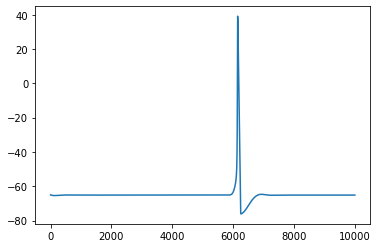

In [26]:
a = 5.0
c = 2.0
dt = 0.025

I_params = np.array([a, c])

fwd = fwd_model(b, dt)
print(fwd.m)
plt.plot(fwd.integrate_HH(I_params))
print(fwd.m)

0.05196683323263447


0.05196683323263447

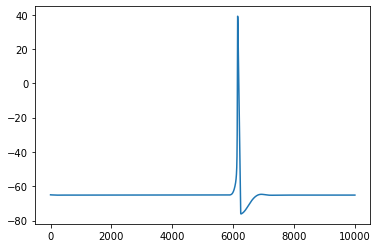

In [27]:
print(fwd.m)
fwd.integrate_HH(I_params)
plt.plot(fwd.integrate_HH(I_params))
fwd.m

0.05
0.05196683323263447


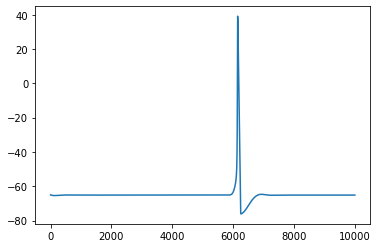

In [28]:
fwd = fwd_model(b, dt)
print(fwd.m)
plt.plot(fwd.integrate_HH(I_params))
print(fwd.m)

In [8]:
# test run forward model

# a = 5.0
# c = 2.0

# I_params = np.array([a, c])

# V_record = integrate_HH(V0, m, h, n, I_params, dt, t)
# I_stimulus = I_params[0]*np.exp(-(t-b)**2/(2*I_params[1]**2))

# plt.plot(t, V_record, label = 'V')
# plt.plot(t, I_stimulus, label = 'I')
# plt.xlabel('time')
# plt.legend()

### Define Cost Function

In [9]:
def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # forward euler solver 
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute cost at time t_i
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2 
                  
    cost = cost/len(data_steps)

    return cost
     

In [10]:
# test and look at total cost before any optimization

a = 5.0
c = 2.0

I_params = np.array([a, c])

total_cost = forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data)
total_cost  

array([97.15208314])

### Compute Gradient

In [11]:
# find AD representation of gradient using autograd
# autograd syntax: grad(f, 0) = gradient of f w.r.t. 0th argument of f
grad_AD = grad(forward_model_cost, 0) 

# test/compute gradient at specific point
# grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)


In [14]:
def fd_check(a, c, param_idx, V0, m, h, n, dt, t, data_steps, V_data):

    # Make log-log plot of gradient finite difference error vs. step size
    
    step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
    p = np.random.randint(0,5000)

    if param_idx == 0:
        A1 = np.random.uniform(0,10)
        I1 = np.array([A1, c])
        title = 'Amplitude'
    
    elif param_idx == 1:
        c1 = np.random.uniform(0, 5)
        I1 = np.array([a, c1])
        title = 'Duration'
    
    else:
        msg = print('can only perform FD check for amplitude (idx = 0) or duration (idx = 1)')
        return msg
    
    L1 = forward_model_cost(I1, V0, m, h, n, dt, t, data_steps, V_data)

    # compute gradient using autograd
    g = grad_AD(I1, V0, m, h, n, dt, t, data_steps, V_data)[param_idx]
    dL_dV_p = np.dot(g, p)

    grad_errs = list()
    for s in step_sizes:

        # compute gradient using finite differences
        if param_idx == 0:
            A2 = A1 + s*p
            I2 = np.array([A2, c])
        
        elif param_idx == 1:
            c2 = c1 + s*p
            I2 = np.array([a, c2])

        L2 = forward_model_cost(I2, V0, m, h, n, dt, t, data_steps, V_data)
        dL_dV_p_diff = (L2 - L1) / s


        # compute gradient error
        grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
        print('step size=', s, ', example gradient finite difference error=', grad_err)

        grad_errs.append(grad_err)
        

    plt.loglog(step_sizes, grad_errs)
    plt.title('Finite Difference Gradient Check for ' + title)
    plt.xlabel('step size')
    plt.ylabel('error')

step size= 1.0 , example gradient finite difference error= [222.81890134]
step size= 0.1 , example gradient finite difference error= [23.17242585]
step size= 0.01 , example gradient finite difference error= [12.08916123]
step size= 0.001 , example gradient finite difference error= [1.88083358]
step size= 0.0001 , example gradient finite difference error= [0.47128888]
step size= 1e-05 , example gradient finite difference error= [0.00654079]
step size= 1e-06 , example gradient finite difference error= [0.00045416]
step size= 1e-07 , example gradient finite difference error= [4.34073386e-05]
step size= 1e-08 , example gradient finite difference error= [4.31885809e-06]
step size= 1e-09 , example gradient finite difference error= [4.15084887e-07]
step size= 1e-10 , example gradient finite difference error= [5.99203999e-08]
step size= 1e-11 , example gradient finite difference error= [2.82585994e-07]
step size= 1e-12 , example gradient finite difference error= [1.21520356e-05]
step size= 1e-

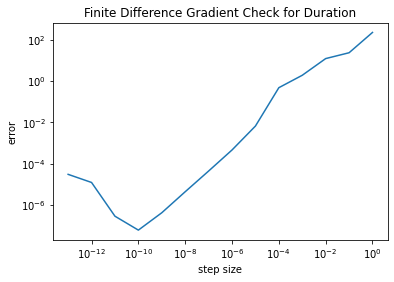

In [18]:
fd_check(a, c, 1, V0, m, h, n, dt, t, data_steps, V_data)

### Find Minimizer

In [12]:
# set initial guess
initial_guess = np.array([a, c])


# print out at every iteration
def callback(x):
    error = forward_model_cost(x, V0, m, h, n, dt, t, data_steps, V_data)
    print(f"Iteration: {callback.iteration}, x: {x}, Cost: {error}")
    callback.iteration += 1
   

callback.iteration = 0

# discussions of method to choose:
# https://stackoverflow.com/questions/42424444/scipy-optimisation-newton-cg-vs-bfgs-vs-l-bfgs
# https://stackoverflow.com/questions/58925576/how-to-choose-proper-method-for-scipy-optimize-minimize
# Nelder-Mead doesn't use the gradient
# use L-BFGS-B if we have bounds
# use CG or BFGS otherwise
method = 'CG' #'L-BFGS-B' #'BFGS' 

# optimization
optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, callback = callback, method = method)


optim

Iteration: 0, x: [5.2486514  2.44403657], Cost: [83.5966305]
Iteration: 1, x: [5.24867574 2.44408256], Cost: [83.59663023]
Iteration: 2, x: [5.24189067 2.44799063], Cost: [83.59662857]
Iteration: 3, x: [5.24185719 2.44802109], Cost: [83.59662857]
Iteration: 4, x: [5.24149443 2.44824213], Cost: [83.59662856]
Iteration: 5, x: [5.2407954  2.44864627], Cost: [83.59662855]
Iteration: 6, x: [5.24079037 2.44863757], Cost: [83.59662854]


     fun: 83.596628535931
     jac: array([-1.54390102e-06,  9.04387424e-07])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 7
    njev: 19
  status: 0
 success: True
       x: array([5.24079037, 2.44863757])

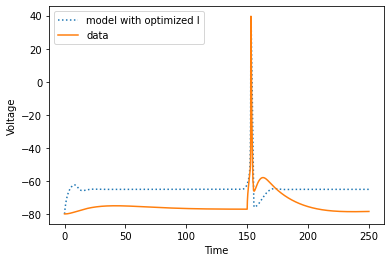

In [13]:
# compute V with optimal I
V_final = integrate_HH(V0, m, h, n, optim.x, dt, t)

plt.figure()
plt.plot(t, V_final, ls = 'dotted', label = 'model with optimized I')
plt.plot(data_steps, V_data, label = 'data')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()